## XYZ Airlines Customer Segmentation Technical Document

In this team project, we are acting as consultants to a xyz based airline, XYZ. Our goal is to give them a better understaning of the people who fly XYZ. We also want to make sure that online booking channels meet the expectations of twenty-first century travelers. 

By doing so, XYZ could drag more customer and drive enrollment in Rewards, therefore help XYZ to refine and market that program.
we settled on clustering based customer segmentation to help us determine the spending patterns of customers and segment them into meaningful groups.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
#nbagg 
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

## Data Cleaning

The data set provided by XYZ airline contains 3 years of flights data , over 3M+ records. 

We first clean the data and aggregate data per flights to customer level. We remove any outliers in data, for example, customers whose age is negative or greater than 100. This is important as we do not want our clustering analysis to be skewed by these data points, as we know most clustering algorithms are sensitive to outliers.

We found that the dataset was made up of booking information from many airlines. So we filtered out irrelevant information and left data that belonged to XYZ Airlines. Then we processed the data set and used 'EncryptedName','GenderCode' and ‘birthdateid 'to determine unique customers. In order to improve the quality of customerbase data, we remove the outliers of customer age and gender. We also explored the booking channel and removed information about customers who booked at the airport, that's only 1% of our dataset. At the same time, we subdivide the booking channels into two major booking channels, SCA booking and outside booking. We create a new column called earlybook day to better analyze days gap between service start date and ticket booking date.

In [ ]:
#clean data first, remove outliers and fill na values
def base(data_df):
    #filter unuseful data
    data_df = data_df[data_df['MarketingAirlineCode']=='SY']
    data_df = data_df[~data_df['GenderCode'].isna()]
    data_df = data_df[(data_df['Age'] >=0) & (data_df['Age']<=100)]
    
    #transfer string to date type
    data_df['PNRCreateDate'] = pd.to_datetime(data_df['PNRCreateDate'])
    data_df['ServiceStartDate'] = pd.to_datetime(data_df['ServiceStartDate'])
    data_df['EnrollDate'] = pd.to_datetime(data_df['EnrollDate'])
    
    data_df['year'] = data_df['PNRCreateDate'].dt.year
    data_df['month'] = data_df['PNRCreateDate'].dt.month
    
    #fill 0 to null value and transfer cardholder to onehot-encoding
    data_df['CardHolder'] = data_df['CardHolder'].fillna(False)
    data_df['CardHolder'] = data_df['CardHolder'].astype(int)
    
    #put discount code 
    data_df['dicount_code'] = (~data_df['BookedProduct'].isna()).astype(int)
    
    #book channel
    sca = ['SCA Website Booking','SY Vacation']
    data_df['SCA'] = data_df['BookingChannel'].isin(sca).astype(int)
    data_df['outside'] = (~data_df['BookingChannel'].isin(sca)).astype(int)
    
    channel = ['Outside Booking', 'SCA Website Booking', 'Reservations Booking',
               'SY Vacation', 'Tour Operator Portal']
    
    data_df.loc[~data_df['BookingChannel'].isin(channel), 'BookingChannel'] = 'airport'
    
    data_df = data_df.merge(pd.get_dummies(data_df['BookingChannel']), 
                            left_index=True, right_index=True)
    
    
    
    #flights in each quarter
    data_df['Q1'] = data_df['ServiceStartDate'].dt.month.between(1,3).astype(int)
    data_df['Q2'] = data_df['ServiceStartDate'].dt.month.between(4,6).astype(int)
    data_df['Q3'] = data_df['ServiceStartDate'].dt.month.between(7,9).astype(int)
    data_df['Q4'] = data_df['ServiceStartDate'].dt.month.between(10,12).astype(int)
    return data_df

In [ ]:
# customer level information
def cutomer_data(data_df):
    #early book
    data_df['earlybook'] = (data_df['ServiceStartDate'] - data_df['PNRCreateDate']).dt.days
    
    #class get dummy
    data_df = data_df.merge(pd.get_dummies(data_df['BkdClassOfService']), 
                                   left_index=True, right_index=True)
    
    #upgrade or not
    f_class = {'Coach':1,'First Class':3, 'Discount First Class':2 }
    data_df["BkdClassOfService_scale"] = data_df["BkdClassOfService"].replace(f_class)
    data_df["TrvldClassOfService_scale"] = data_df["TrvldClassOfService"].replace(f_class)
    data_df['upgrade'] = (data_df['BkdClassOfService_scale']<
                          data_df['TrvldClassOfService_scale']).astype(int)
    
    #member dummy
    data_df['Standard'] = (data_df['UflyMemberStatus'] == 'Standard').astype(int)
    data_df['Elite'] = (data_df['UflyMemberStatus'] == 'Elite').astype(int)
    data_df['Gender'] = (data_df['GenderCode'] == 'M').astype(int)
    
    #aggregate data
    data = data_df.groupby(['EncryptedName','GenderCode','birthdateid']).agg(
     age = ('Age','mean'),
     gender = ('Gender','mean'),
     total_flights = ('Age','size'),
     total_bookings = ('TicketNum', 'nunique'),
     first_flight = ('PNRCreateDate','min'),
     avg_earlybook = ('earlybook','mean'),
     avg_coach = ('Coach','mean'),
     total_coach = ('Coach','sum'),
     avg_discount_first_class = ('Discount First Class','mean'),
     total_discount_first_class = ('Discount First Class','sum'),
     avg_first_class = ('First Class','mean'),
     total_first_class = ('First Class','sum'),
     avg_upgrade = ('upgrade','mean'),
     total_upgrade = ('upgrade','sum'),
     avg_basefareamt = ('BaseFareAmt','mean'), 
     total_basefareamt = ('BaseFareAmt','sum'),
     avg_docamt = ('TotalDocAmt','mean'),
     total_docamt = ('TotalDocAmt','sum'),
     standard = ('Standard','max'),
     elite = ('Elite','max'),
     enrolldate = ('EnrollDate','min'),
     cardholder = ('CardHolder','max'),
     avg_discount = ('dicount_code','mean'),
     total_discount = ('dicount_code','sum'),
     outside = ('outside', 'mean'),
     total_outside = ('outside', 'sum'),
     sca_booking = ('SCA','mean'), 
     total_sca_booking = ('SCA','sum'), 
     q2 = ('Q2','mean'),
     q3 = ('Q3','mean'),
     q4 = ('Q4','mean'),
     q1_total = ('Q1','sum'),
     q2_total = ('Q2','sum'),
     q3_total = ('Q3','sum'),
     q4_total = ('Q4','sum'),)
    
    data = data.reset_index()
    
    #member
    data['member'] = (~data['enrolldate'].isna()).astype(int)
    
    #flights before enroll date
    new_df = pd.merge(data_df[['EncryptedName','GenderCode','birthdateid','PNRCreateDate']], 
                      data[['EncryptedName','GenderCode','birthdateid','enrolldate','standard','elite']], 
                      how = 'left', 
                      left_on = ['EncryptedName','GenderCode','birthdateid'],
                      right_on = ['EncryptedName','GenderCode','birthdateid'])
    
    new_df = new_df[~new_df['enrolldate'].isna()]
    after = new_df[new_df['PNRCreateDate']<new_df['enrolldate'].dt.date].groupby(['EncryptedName','GenderCode','birthdateid']).size().to_frame('flights_before_enroll').reset_index()
    
    data = data.merge(after,
                      how = 'left', 
                      left_on = ['EncryptedName','GenderCode','birthdateid'],
                      right_on = ['EncryptedName','GenderCode','birthdateid'])
    
    data['flights_before_enroll'] = data['flights_before_enroll'].fillna(0)
    
    
    return data
    
    

In [ ]:
# import raw dataset
df = base(pd.read_csv('XYZ.csv'))

In [ ]:
# create customer based data
customer = cutomer_data(df)

## Explore customer based data

<AxesSubplot:ylabel='None'>

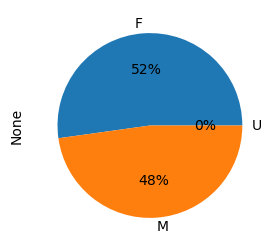

In [ ]:
customer.groupby('GenderCode').size().plot.pie(
                y='mass', figsize=(3, 3),autopct='%1.0f%%')

<AxesSubplot:xlabel='year,month'>

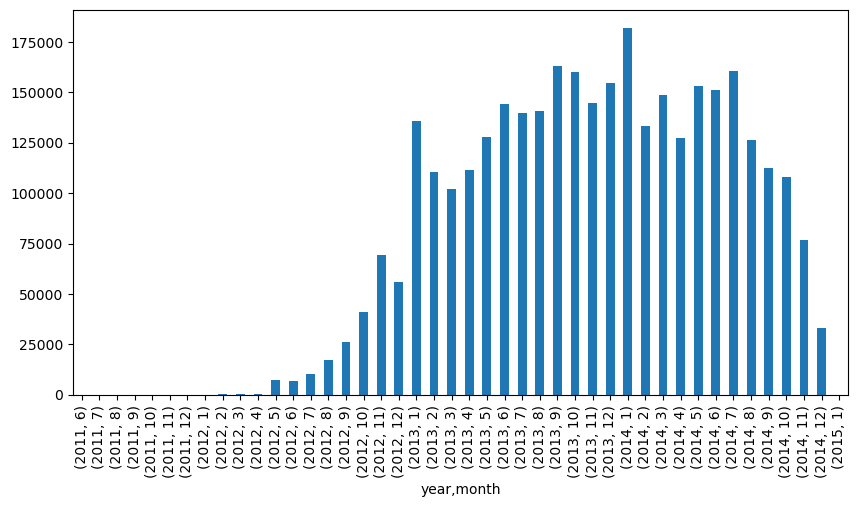

In [ ]:
df.groupby(['year','month']).size().plot(
                kind = 'bar',figsize = (10,5))

<AxesSubplot:ylabel='None'>

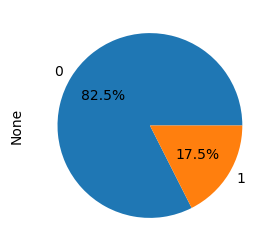

In [ ]:
customer.groupby('member').size().plot.pie(
                y='mass', figsize=(3, 3),autopct='%1.1f%%')

<AxesSubplot:xlabel='ServiceEndCity'>

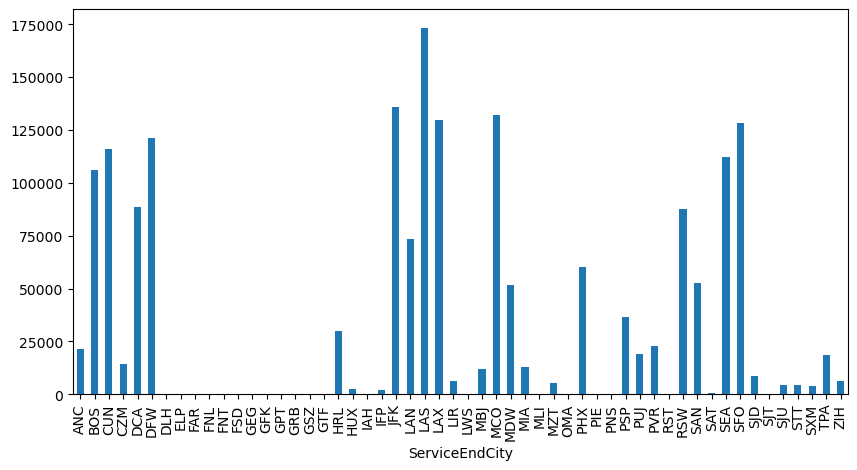

In [ ]:
df[df['ServiceEndCity']!='MSP'] \
                .groupby('ServiceEndCity').size().plot(kind = 'bar',figsize = (10,5))

In [ ]:
df['customer_id'] = df['EncryptedName'] + \
                                df['GenderCode'] + \
                                df['birthdateid'].astype(str)

temp = df.groupby('ServiceStartCity')['customer_id'] \
                                .nunique().reset_index(). \
                                sort_values(by=['customer_id'], ascending = False)

# Proprtion of customers by ServiceStartCity
temp['proportion'] = (temp['customer_id']/1527244)*100

temp.head()

,ServiceStartCity,customer_id,proportion
31,MSP,1278931,83.741105
22,LAS,155272,10.166810
20,JFK,117882,7.718609
27,MCO,115781,7.581041
23,LAX,113177,7.410538


In [ ]:
temp2 = df.groupby('ServiceEndCity')['customer_id'] \
                .nunique().reset_index() \
                .sort_values(by=['customer_id'], ascending = False)

# Proprtion of customers by ServiceEndCity
temp2['proportion'] = (temp2['customer_id']/1527244)*100

temp2.head()

,ServiceEndCity,customer_id,proportion
33,MSP,1275870,83.540679
24,LAS,155082,10.154370
29,MCO,117207,7.674412
22,JFK,115327,7.551315
25,LAX,112871,7.390502


## Clustering

To reduce noises and improve computation effeciency, we choose to implement PCA fisrt.

Before that, the data first needed to be normalized to account for the
different magnitudes in ranges. We normalized the columns using standardized normalization.

In [ ]:
# initial data frame for doing customer analysis
# include only columns that will be used in clustering

df1 = customer.loc[:, ['age', 'total_flights',
                                 'avg_earlybook', 'avg_coach', 
                                 'avg_first_class', 'avg_upgrade', 
                                 'avg_basefareamt', 
                                 'avg_discount', 'avg_docamt',  
                                 'outside', 'sca_booking']]
df1.head()

,age,total_flights,avg_earlybook,avg_coach,avg_first_class,avg_upgrade,avg_basefareamt,avg_discount,avg_docamt,outside,sca_booking
0,33.0,1,7.0,1.0,0.0,0.0,151.63,0.0,174.0,0.0,1.0
1,24.0,1,50.0,1.0,0.0,1.0,205.58,0.0,231.9,1.0,0.0
2,54.0,1,0.0,1.0,0.0,0.0,264.19,0.0,294.9,1.0,0.0
3,52.0,2,12.5,1.0,0.0,0.0,0.00,1.0,0.0,1.0,0.0
4,29.0,2,10.0,1.0,0.0,1.0,432.56,0.0,486.8,1.0,0.0


In [ ]:
# implementing PCA
# standardization
df_standard = StandardScaler().fit_transform(df1)

pca_initial = PCA().fit(df_standard)

pca_initial.explained_variance_ratio_

array([2.40163325e-01, 1.72727435e-01, 1.50834870e-01, 1.00780955e-01,
       9.46369566e-02, 8.32395511e-02, 7.92159694e-02, 6.49702173e-02,
       1.31262277e-02, 3.04492183e-04, 1.13028534e-30])

[0.24016332 0.41289076 0.56372563 0.66450659 0.75914354 0.84238309
 0.92159906 0.98656928 0.99969551 1.         1.        ]


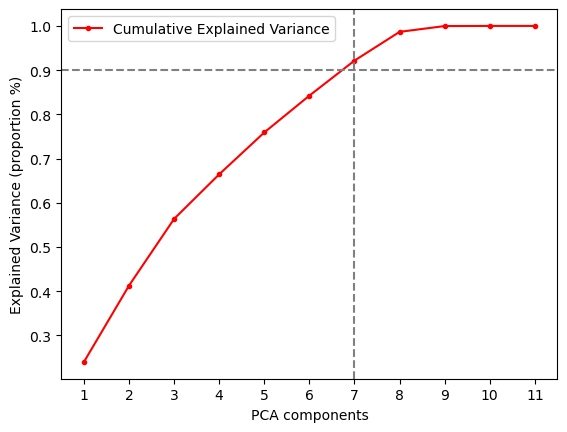

In [ ]:
exp_var = pca_initial.explained_variance_ratio_ 

# cumulative sum of variance explained
exp_var_cumsum = np.cumsum(exp_var)

plt.plot(range(1, len(exp_var)+1),
        exp_var_cumsum,'r.-',label='Cumulative Explained Variance')

plt.legend()
ax = plt.gca()
ax.set_xticks(range(1, len(exp_var)+1))
ax.set_xlabel('PCA components')
ax.set_ylabel('Explained Variance (proportion %)')

# which shows that the first two PCs accounts for more than 90% of the variance of the data.
plt.axhline(0.9,linestyle='--',color='grey')
plt.axvline(7,linestyle='--',color='grey')

print(exp_var_cumsum)

To keep the most information while has the lowest noise and dimensions, we choose the number of componets that capture 90% of the variance. (n = 7)

In [ ]:
pca = PCA(n_components=7)
df_reduced_dim = pca.fit_transform(df_standard)

We choose Kmeans because it can be used for all of the data. Also, it is very simple and powerful method. 

To get an idea of how many groups to cluster the data into, we decided to employ both quantitative as well as visual techniques to choose the ideal number of clusters. For the quantitative approach we analyzed
the sum-of-squared-errors (SSE) and draw the elbow curve.

In [ ]:
distortions = []

#score = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_reduced_dim)
    distortions.append(kmeanModel.inertia_)
    #score.append(silhouette_score(X_normalized, kmeans.labels_))

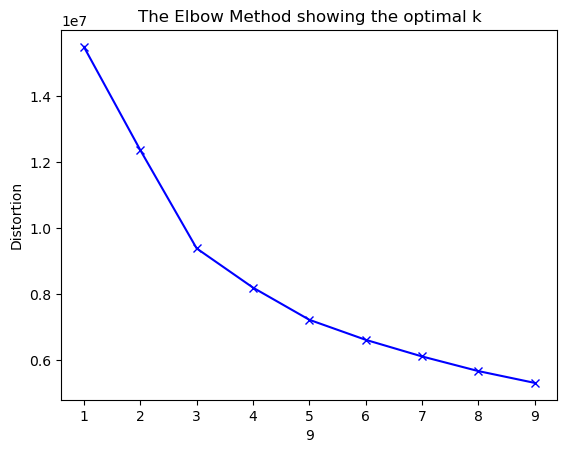

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel(k)
plt.ylabel('Distortion')
ax = plt.gca()
ax.set_xticks(range(1,k+1))
plt.title('The Elbow Method showing the optimal k')
plt.show()

For the above plot, there is no sharp elbow in this curve that clearly identifies a single best clustering solution. The elbow in the
curve is anywhere from three to five clusters. In order to target customer more precisely, we use k=5 to cluster the customer level dataset.

In [ ]:
# Choose cluster = 5
kmeans = KMeans(n_clusters = 5, random_state = 1)
kmeans.fit(df_reduced_dim)

KMeans(n_clusters=5, random_state=1)

## Analyze Cluster

With our clustering solution set, next we analyzed and interpreted the five groups starting with the centroids of the normalized data.

In [ ]:
analysis_df = customer.copy()
analysis_df['label'] = kmeans.labels_

In [ ]:
# Rename each cluster
analysis_df['label'] = analysis_df['label'].replace(0,'SCA bookers')
analysis_df['label'] = analysis_df['label'].replace(1,'FICF')
analysis_df['label'] = analysis_df['label'].replace(2,'OTLS')
analysis_df['label'] = analysis_df['label'].replace(3,'Upgraders')
analysis_df['label'] = analysis_df['label'].replace(4,'Outside Bookers')

In [ ]:
# Explore each cluster
analysis_df.groupby('label').mean().round(decimals=2).T

label,FICF,OTLS,Outside Bookers,SCA bookers,Upgraders
birthdateid,41374.63,46013.69,45647.94,44931.70,42524.19
age,49.95,37.24,38.22,40.20,46.74
gender,0.55,0.48,0.49,0.46,0.52
total_flights,2.47,1.87,2.48,2.19,2.57
total_bookings,1.53,1.11,1.21,1.26,1.42
avg_earlybook,55.55,40.36,64.80,63.89,56.32
avg_coach,0.09,1.00,1.00,1.00,0.99
total_coach,0.30,1.87,2.48,2.18,2.50
avg_discount_first_class,0.00,0.00,0.00,0.00,0.00
total_discount_first_class,0.00,0.00,0.00,0.00,0.00


Visualizations and plot required for Slide deck and Executive Summary

([<matplotlib.axis.YTick at 0x7f7e0c6ec880>,
 [Text(0, 0, '0'),
  Text(0, 100000, '100,000'),
  Text(0, 200000, '200,000'),
  Text(0, 300000, '300,000'),
  Text(0, 400000, '400,000'),
  Text(0, 500000, '500,000'),
  Text(0, 600000, '600,000')])

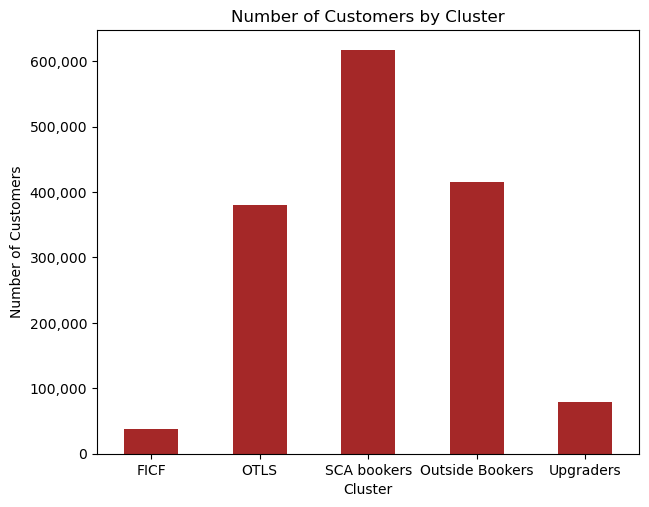

In [ ]:
#Cluster Size
analysis_df.groupby('label')['age'].count() \
            .loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
            .plot(kind = 'bar',
                  ylabel = 'Number of Customers',
                  xlabel = 'Cluster',
                  title = "Number of Customers by Cluster", 
                  color = '#A52828', 
                  rot = 0, figsize = (7,5.5), fontsize=10)
x=range(0,650000,100000)
plt.yticks(x,[format(i,',') for i in x])

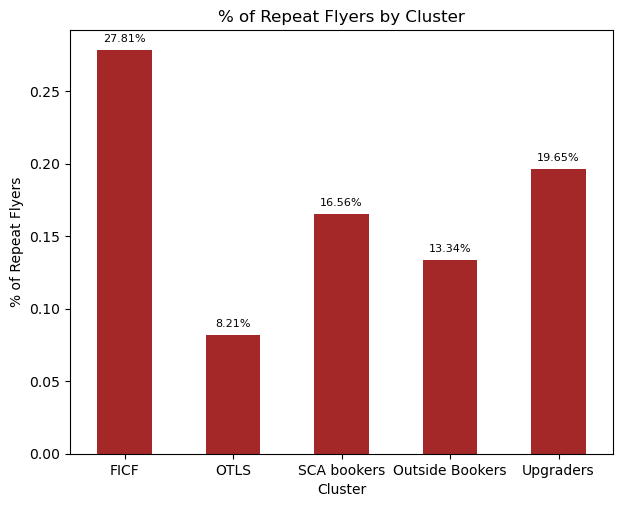

In [ ]:
# repeated customer
df_repeat = analysis_df.groupby('label')['age'].count()
df_repeat = df_repeat.reset_index()
df_repeat['repeat'] = analysis_df[analysis_df.total_bookings > 1].groupby('label')['age'].count().values
df_repeat['proportion'] = df_repeat['repeat'] / df_repeat['age']
plots = df_repeat.set_index('label') \
            .loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
            .plot(y = 'proportion',kind = 'bar', rot = 0, 
                             color = '#A52828',
                             ylabel = '% of Repeat Flyers',
                             xlabel = "Cluster",
                             title = '% of Repeat Flyers by Cluster', 
                             figsize = (7,5.5), fontsize=10,
                             legend = False)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

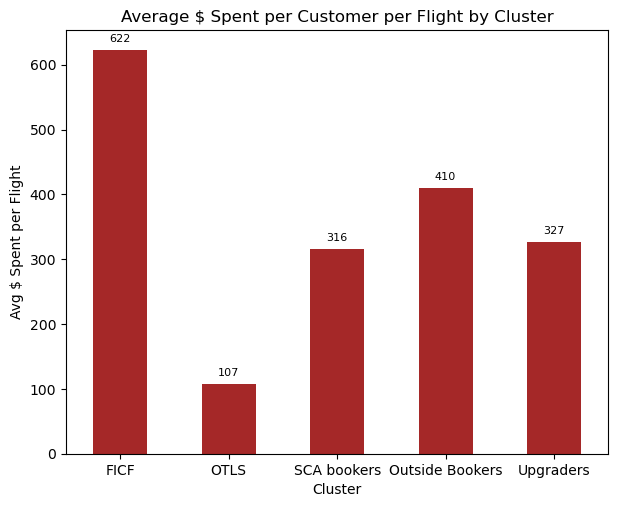

In [ ]:
plots = analysis_df.groupby('label')['avg_docamt'].mean() \
.loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
                    .plot(kind = 'bar',
                            title = "Average $ Spent per Customer per Flight by Cluster",
                            ylabel = 'Avg $ Spent per Flight',
                            xlabel = 'Cluster',
                            width = 0.5,color='#A52828',rot = 0, figsize = (7,5.5), fontsize=10)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

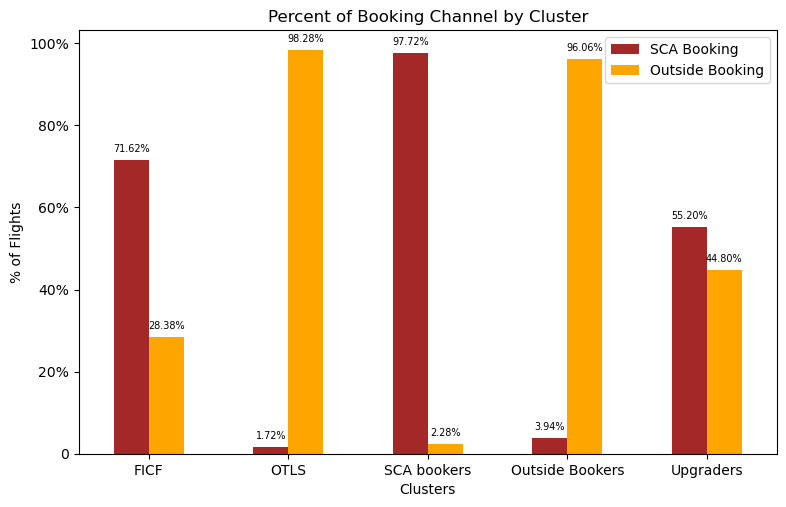

In [ ]:
df2 =  analysis_df.groupby('label')['total_outside'].sum()
df1 =  analysis_df.groupby('label')['total_sca_booking'].sum()
total_fights = analysis_df.groupby('label')['total_flights'].sum()

booking_flights = pd.DataFrame()
booking_flights["SCA Booking"] = df1/total_fights
booking_flights["Outside Booking"] = df2/total_fights

plots = booking_flights.loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
                        .plot(kind = 'bar',width = 0.5,xlabel = "Clusters",ylabel = '% of Flights',color = ['#A52828','#FFA500'],figsize = (9,5.5),rot = 0,
                              title = "Percent of Booking Channel by Cluster", fontsize = 10)

plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8,1.0], [0, '20%', '40%', '60%', '80%',"100%"])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2%'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')


SCA bookers have over 99% of the bookings come from the SCA Website or SY Vacation. This is the largest cluster with 617,000 customers, which is 40% of all SCA customers. 

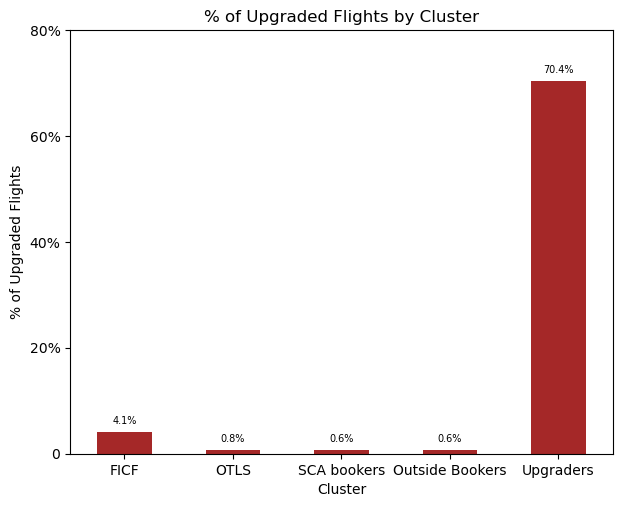

In [ ]:
# proportion of flights upgraded
upgrade_total = analysis_df[['label', 'total_flights', 'total_upgrade']].groupby('label').sum()
plots = (upgrade_total['total_upgrade']/upgrade_total['total_flights']) \
                        .loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
                        .plot(kind = 'bar',
                                title = "% of Upgraded Flights by Cluster",
                                ylabel = '% of Upgraded Flights',
                                xlabel = 'Cluster',
                                width = 0.5,
                                color='#A52828',
                                rot = 0, 
                                figsize = (7,5.5),
                                fontsize=10)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8], [0, '20%', '40%', '60%', '80%'])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1%'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')

The last cluster has 70% of all the upgraded flights among all the clusters, which is 65% more upgrades than any other cluster, so we names it as "Upgraders”.

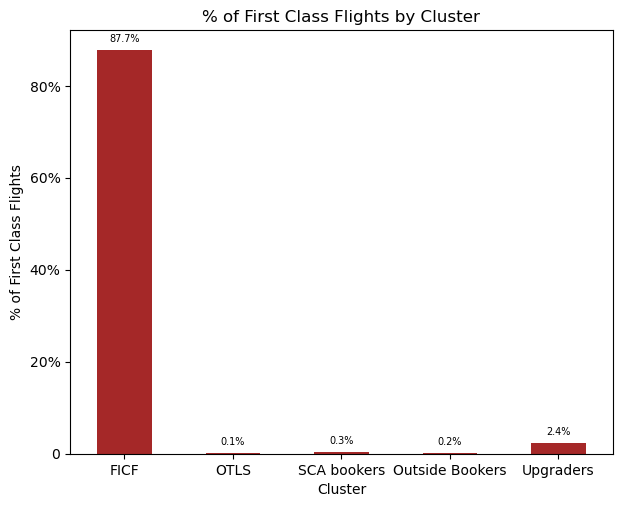

In [ ]:
#propotion for first class flights
first_class_flights = analysis_df.groupby('label')['total_first_class'].sum()
total_fights = analysis_df.groupby('label')['total_flights'].sum()

plots = (first_class_flights/total_fights).loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
                        .plot(kind = 'bar',
                                title = "% of First Class Flights by Cluster",
                                ylabel = '% of First Class Flights',
                                xlabel = 'Cluster',
                                width = 0.5,
                                color='#A52828',
                                rot = 0, 
                                figsize = (7,5.5),
                                fontsize=10)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8], [0, '20%', '40%', '60%', '80%'])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1%'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')

There are 27.8% of the customers in this cluster are repeated flyers, and 87.7% of flights taken in the clusters are first-class flights. 

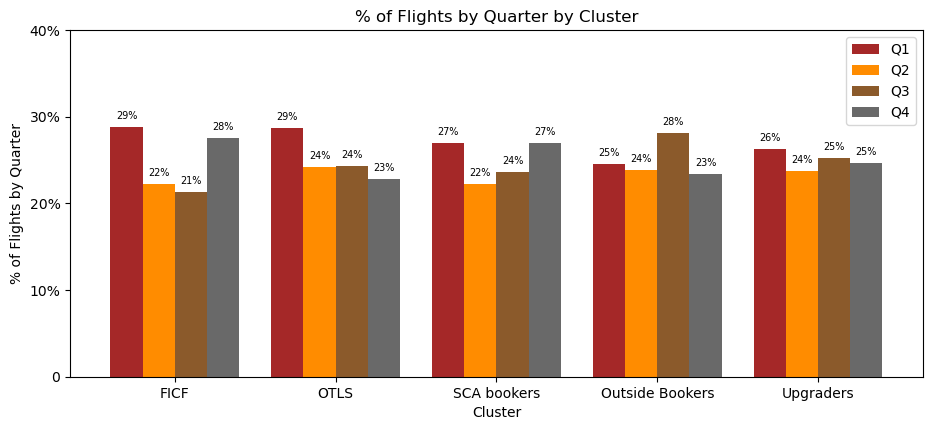

In [ ]:
# % of Flights by Quarter by Cluster
total_fights = analysis_df.groupby('label')['total_flights'].sum()

time_booked = pd.DataFrame()
time_booked["Q1"] = analysis_df.groupby('label')['q1_total'].sum()/total_fights
time_booked["Q2"] = analysis_df.groupby('label')['q2_total'].sum()/total_fights
time_booked["Q3"] = analysis_df.groupby('label')['q3_total'].sum()/total_fights
time_booked["Q4"] = analysis_df.groupby('label')['q4_total'].sum()/total_fights

plots = time_booked.loc[['FICF', 'OTLS', 'SCA bookers', 'Outside Bookers', 'Upgraders']] \
                        .plot(kind = 'bar',
                                title = "% of Flights by Quarter by Cluster",
                                ylabel = '% of Flights by Quarter',
                                xlabel = 'Cluster',
                                width = 0.8,
                                color=['#A52828', '#FF8C00', '#8B5A2B' , '#696969'],
                                rot = 0, 
                                figsize = (11,4.5),
                                fontsize=10)
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4], [0, '10%', '20%', '30%', '40%'])

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.0%'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 8),
                   textcoords='offset points')

In [ ]:
# calculating number by non-members, members and elite

df['UflyMemberStatus'] = df.UflyMemberStatus.fillna('Non-member')

df["cust_identifier"] = df["EncryptedName"].astype(str) \
                                        + df["GenderCode"].astype(str) \
                                        + df["birthdateid"].astype(str)

num_customers = df[["cust_identifier", "UflyMemberStatus"]] \
                                        .groupby("UflyMemberStatus") \
                                        .nunique()['cust_identifier']

total_flights = df.groupby("UflyMemberStatus")['PNRLocatorID'].count()

total_bookings = df.groupby("UflyMemberStatus")['PNRLocatorID'].nunique()

total_revenue = df.groupby("UflyMemberStatus")['TotalDocAmt'].sum()

flights_per_cust = df.groupby(["cust_identifier", "UflyMemberStatus"]) \
                                        [['PNRLocatorID']].nunique()

num_repeat = flights_per_cust[flights_per_cust.PNRLocatorID > 1] \
                                        .groupby("UflyMemberStatus")['PNRLocatorID'].count()

sca_booking = df[df.BookingChannel
                                        .isin(['SCA Website Booking', 'SY Vacation', 'SCA'])] \
                                        .groupby("UflyMemberStatus")['PNRLocatorID'].nunique()

member_level_stats = pd.DataFrame()

member_level_stats["average_flights"] = total_flights/num_customers

member_level_stats["average_amount_per_flight"] = total_revenue/total_flights

member_level_stats["average_repeat_customers"] = num_repeat/num_customers

member_level_stats["sca_website_booking"] = sca_booking/total_bookings

member_level_stats.loc[["Non-member", "Standard", "Elite"]].T

UflyMemberStatus,Non-member,Standard,Elite
average_flights,2.077851,2.539097,11.076625
average_amount_per_flight,306.899173,336.741916,458.922390
average_repeat_customers,0.098137,0.236816,0.630031
sca_website_booking,0.408857,0.727770,0.717687


## Findings:
Based on above analysis, we come up with below findings:

#### Cluster 1: Frequent 1st-Class Flyers
There is 27.8% of the customers in this cluster are repeated flyers, and 87.7% of flights taken in the clusters are first-class flights. On average, this cluster spent $622 on a flight, which is \$200 more than any other cluster. This is the smallest cluster, with 2.4% of all customers. Of the 38% of customers in the cluster who are Ufly members, 97.3% are standard members. <br><br>

#### Cluster 2: One Time Low Spenders
This cluster has only 8% repeat flyers, which is 5% less than any other cluster. This cluster is distinct by how, on average, customers spend \$107 per flight, which is over $200 less than any other cluster.<br><br>


#### Cluster 3: SCA Bookers
The cluster has over 99% of the bookings come from the SCA Website or SY Vacation. This is the largest cluster with 617,000 customers, which is 40% of all SCA customers. Repeat flyers in this cluster is 16%, which is the median of all the clusters.<br><br>


#### Cluster 4: Outside Bookers
This cluster almost exclusively books from outside channels, any website other than SCA Website or SY Vacation. There is a cluster size of 415,000 customers, with 27% of all customers, and the most popular time to fly is in Quarter 3. It also has the second lowest membership proportion of 11% of customers being members.<br><br>

#### Cluster 5: Upgraders
The last cluster is distinctly defined by the percentage of seat upgrades. This cluster has 70% of all the upgraded flights among all the clusters, which is 65% more upgrades than any other cluster. They spend an average of $316 per flight, and 19.6% of customers are repeat flyers. They make up 70% of all upgrades yet only purchase 3.5% of first-class flight purchases.


## Appendix

Below are the python codes for other clustering solutions we tried.

In [ ]:
#DBSCAN code
from sklearn.cluster import DBSCAN
customer= customer.sample(frac = 0.25)
x = MinMaxScaler().fit_transform(customer)
clustering = DBSCAN(eps=0.08, min_samples=10).fit(x)
cluster_result = pd.DataFrame(customer.copy())
cluster_result.loc[:,'Cluster'] = clustering.labels_

In [ ]:
#GMM Code
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from adspy_shared_utilities import plot_labelled_scatter
import matplotlib.pyplot as plt


gdf = customer[['birthdateid',
    'age',
'total_flights',      
'total_earlybook',     
'total_coach',         
'total_discount_first_class',
'total_first_class',   
'total_upgrade',       
'total_basefareamt',   
'total_docamt',        
'total_direct',        
'total_short_halt',    
'total_long_halt',            
'total_discount',             
'q1',                  
'q2',                  
'q3',                  
'q4',                                     
'flights_before_enroll']]
gdf['total_earlybook'] = gdf['total_earlybook'].str.split(" ").str[0]



cls = GaussianMixture(n_components = 5)
cls_assignment = cls.fit_predict(gdf)


plt.scatter(gdf.iloc[:, 1], gdf.iloc[:, 2], c=cls_assignment, s=40, cmap='viridis')
gdf['cluster'] = cls_assignment
gdf.cluster.value_counts()
gdf.groupby('cluster').agg({'age':'mean',
                            'total_flights':'mean'})